In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt

from core import *

# Prepare mesh

In [2]:
xs = np.linspace(0, 1, 9)
ys = np.linspace(0, 1, 9)

xs, ys = np.meshgrid(xs, ys)

# edges
n_edges = 8*9 + 8*9 + 8*8
adjacency_list = []

for i in range(81):
    if (i+1) % 9 != 0:
        adjacency_list.append([i, i+1])

for i in range(72):
    adjacency_list.append([i, i+9])

for i in range(72):
    if (i+1) % 9 != 0:
        adjacency_list.append([i, i+10])

adjacency_list = torch.tensor(adjacency_list)

senders_one = adjacency_list[:, 0].flatten()
receivers_one = adjacency_list[:, 1].flatten()
senders = torch.cat([senders_one, receivers_one]).to(device)
receivers = torch.cat([receivers_one, senders_one]).to(device)

edge_features = [0.125] * (8*9) + [0.125] * (8*9) + [np.sqrt(2) * 0.125] * (8*8)
edge_features += edge_features
edge_features = torch.tensor(edge_features).view(-1, 1).float().to(device)
edge_set = EdgeSet(senders, receivers, edge_features)

In [3]:
def get_graphs(p=1.0):
    # nodes
    n_nodes = 9*9

    node_types = np.zeros([9, 9])
    node_types[0, :] = 1
    node_types[-1, :] = 1
    node_types[:, 0] = 1
    node_types[:, -1] = 1

    node_types_np = node_types.flatten()
    node_types = F.one_hot(torch.tensor(node_types.reshape(-1), dtype=int)).to(device)

    u_d = lambda x, y: p + x**2 + 2*y**2 # p is a parameter

    u_sol = u_d(xs, ys).reshape(-1)

    u_pred = np.ones_like(u_sol)
    u_pred[node_types_np == 1] = u_sol[node_types_np == 1]

    node_features_exact = torch.tensor(u_sol).view(-1, 1).float().to(device)
    node_features = torch.tensor(u_pred).view(-1, 1).float().to(device)

    node_features_exact = torch.cat([node_types, node_features_exact], axis=-1)
    node_features = torch.cat([node_types, node_features], axis=-1)

    # graph
    graph_init = MultiGraph(node_features, edge_set)
    graph_exact = MultiGraph(node_features_exact, edge_set)
    
    return graph_init, graph_exact

In [17]:
graph_init, graph_exact = get_graphs(p=np.random.uniform(-5.0, 5.0, 1).item())

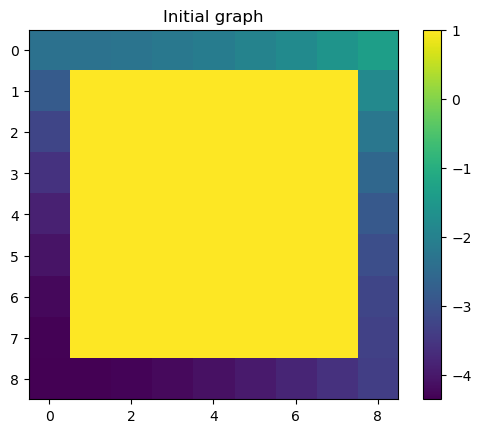

In [18]:
plt.figure()
plt.imshow(graph_init.node_features[:, 2].view(9, 9).detach().cpu().flip(0))
plt.colorbar()
plt.title("Initial graph")
plt.show()

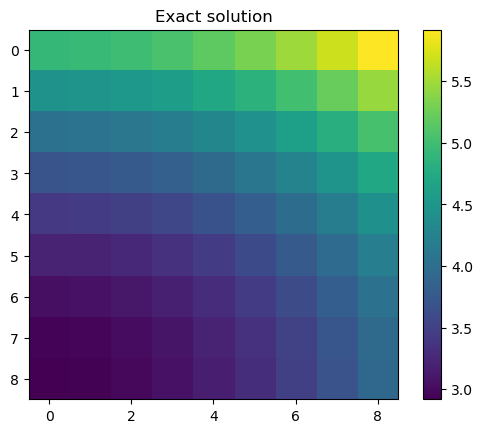

In [10]:
plt.figure()
plt.imshow(graph_exact.node_features[:, 2].view(9, 9).detach().cpu().flip(0))
plt.colorbar()
plt.title("Exact solution")
plt.show()

# Training

In [19]:
def train(model, epochs):
    
    loss_history = []
    
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        
        graph_init, graph_exact = graph_init, graph_exact = get_graphs(p=np.random.uniform(-5.0, 5.0, 1).item())
        
        node_features_pred = model.forward(graph_init).flatten()
        loss = loss_func(node_features_pred, graph_exact.node_features[:, 2])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        print(f"epoch: {epoch+1}, loss: {loss.item()}")
        
        loss_history.append(loss.item())
    
    return node_features_pred, loss_history

In [22]:
model = GraphNet(message_passing_steps=15)

In [23]:
node_features_pred, loss_history = train(model, epochs=500)

epoch: 1, loss: 22.437023162841797
epoch: 2, loss: 6.936834812164307
epoch: 3, loss: 23.83449935913086
epoch: 4, loss: 21.801467895507812
epoch: 5, loss: 6.1235809326171875
epoch: 6, loss: 2.3638131618499756
epoch: 7, loss: 21.968769073486328
epoch: 8, loss: 16.356647491455078
epoch: 9, loss: 18.228219985961914
epoch: 10, loss: 7.789580821990967
epoch: 11, loss: 26.498668670654297
epoch: 12, loss: 0.8758275508880615
epoch: 13, loss: 2.047112464904785
epoch: 14, loss: 1.7393392324447632
epoch: 15, loss: 0.976523220539093
epoch: 16, loss: 11.124651908874512
epoch: 17, loss: 5.347533702850342
epoch: 18, loss: 1.8457332849502563
epoch: 19, loss: 4.744380950927734
epoch: 20, loss: 0.8308806419372559
epoch: 21, loss: 1.6915886402130127
epoch: 22, loss: 1.0785232782363892
epoch: 23, loss: 11.825380325317383
epoch: 24, loss: 7.284207820892334
epoch: 25, loss: 8.69962215423584
epoch: 26, loss: 3.0136985778808594
epoch: 27, loss: 20.857192993164062
epoch: 28, loss: 6.922723293304443
epoch: 29, l

epoch: 232, loss: 0.18264836072921753
epoch: 233, loss: 0.0933680459856987
epoch: 234, loss: 0.16420690715312958
epoch: 235, loss: 1.0856351852416992
epoch: 236, loss: 2.1044387817382812
epoch: 237, loss: 0.03951778635382652
epoch: 238, loss: 0.7330868244171143
epoch: 239, loss: 0.08659841120243073
epoch: 240, loss: 0.2218727320432663
epoch: 241, loss: 0.7037649750709534
epoch: 242, loss: 0.2497345507144928
epoch: 243, loss: 0.7295920848846436
epoch: 244, loss: 2.144254684448242
epoch: 245, loss: 2.7521843910217285
epoch: 246, loss: 0.8443493247032166
epoch: 247, loss: 2.5861878395080566
epoch: 248, loss: 0.4257200360298157
epoch: 249, loss: 0.22361905872821808
epoch: 250, loss: 0.30270472168922424
epoch: 251, loss: 0.615339994430542
epoch: 252, loss: 0.8567376732826233
epoch: 253, loss: 0.6633073091506958
epoch: 254, loss: 0.5822892189025879
epoch: 255, loss: 0.16751722991466522
epoch: 256, loss: 0.06305491924285889
epoch: 257, loss: 0.5421451330184937
epoch: 258, loss: 0.364678233861

epoch: 453, loss: 0.04148393124341965
epoch: 454, loss: 0.3822850286960602
epoch: 455, loss: 0.13684937357902527
epoch: 456, loss: 0.06835754960775375
epoch: 457, loss: 0.039408162236213684
epoch: 458, loss: 0.6310242414474487
epoch: 459, loss: 0.45242196321487427
epoch: 460, loss: 0.6768102049827576
epoch: 461, loss: 0.07061616331338882
epoch: 462, loss: 0.21546043455600739
epoch: 463, loss: 0.5745915770530701
epoch: 464, loss: 0.05814565718173981
epoch: 465, loss: 0.8177502751350403
epoch: 466, loss: 0.3232751488685608
epoch: 467, loss: 0.12286549061536789
epoch: 468, loss: 0.0289189163595438
epoch: 469, loss: 0.08792859315872192
epoch: 470, loss: 0.1911000907421112
epoch: 471, loss: 0.21806608140468597
epoch: 472, loss: 0.4172174334526062
epoch: 473, loss: 0.11853066086769104
epoch: 474, loss: 0.10019952058792114
epoch: 475, loss: 0.1593286544084549
epoch: 476, loss: 0.24656428396701813
epoch: 477, loss: 0.1011873185634613
epoch: 478, loss: 0.06910307705402374
epoch: 479, loss: 0.67

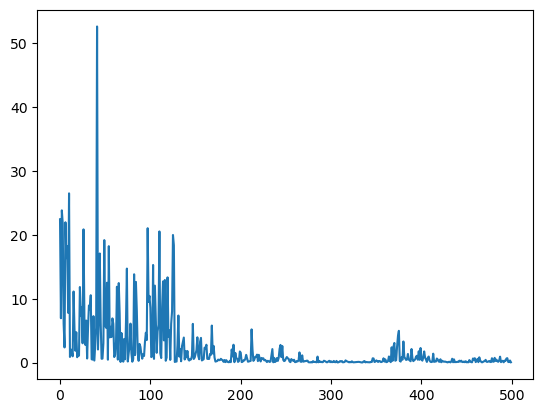

In [25]:
plt.plot(loss_history[0:])

# Inference

In [69]:
graph_init, graph_exact = get_graphs(p=np.random.uniform(-5.0, 5.0, 1).item())

In [70]:
with torch.no_grad():
    node_features_pred = model.forward(graph_init).cpu().view(9, 9)
    node_features_exact = graph_exact.node_features[:, 2].cpu().view(9, 9)

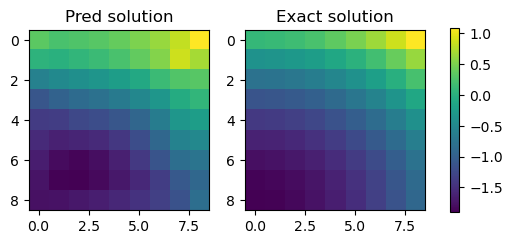

In [71]:
fig, ax = plt.subplots(1, 2)
im0 = ax[0].imshow(node_features_pred.flip(0))
ax[0].set_title("Pred solution")

im1 = ax[1].imshow(node_features_exact.flip(0))
ax[1].set_title("Exact solution")

fig.colorbar(im1, ax=ax, shrink=0.5)
plt.show()

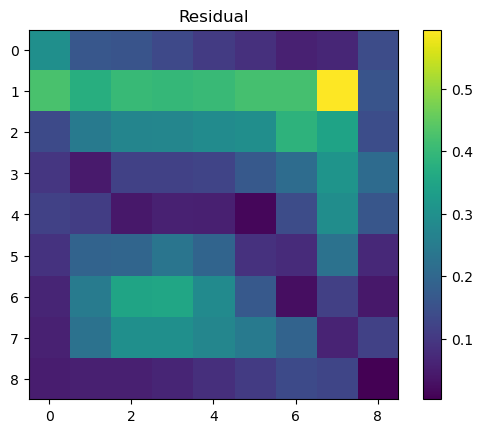

In [72]:
plt.figure()
plt.imshow(abs(node_features_pred - node_features_exact).flip(0))
plt.title("Residual")
plt.colorbar()
plt.show()